## ![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white) **CHAPTER 3 - CLASSIFICATION**

### **This is analysis of the notebook from _Hands-On Machine Learning with Scikit-Learn & TensorFlow_ by Aurélien Géron.**

## **SETUP**

In [4]:
# This notebook requires Python 3.7 or above and Scikit-Learn 1.0.1 or above.
import sys
from packaging import version
import sklearn

assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [5]:
# Common libraries.
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Default settings for matplotlib.
plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)

In [6]:
# Create directory for matplotlib images.
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## ![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white) **MNIST**

In [7]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)

In [8]:
X, y = mnist.data, mnist.target  # type: ignore

In [9]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
X.shape

(70000, 784)

In [11]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [12]:
y.shape

(70000,)

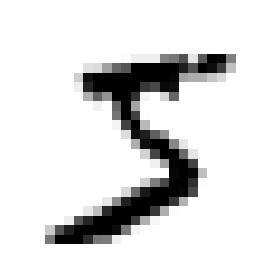

In [13]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")
plt.show()

In [14]:
y[0]

'5'

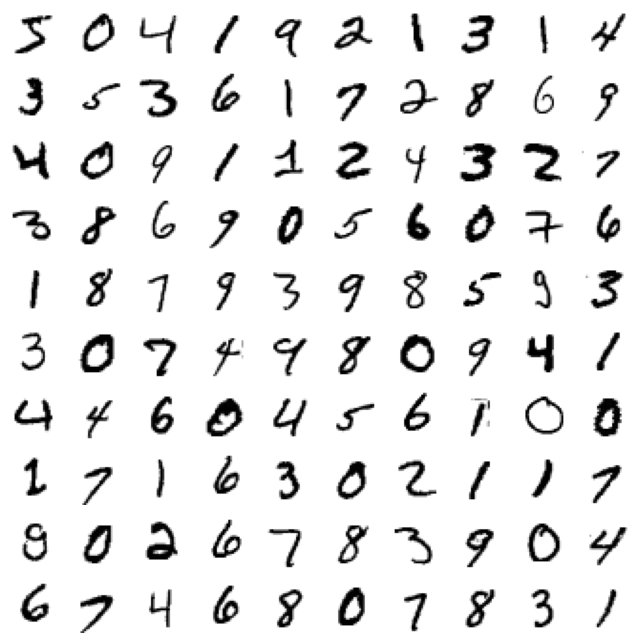

In [15]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)

plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot")
plt.show()

In [16]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

## ![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white) **BINARY CLASSIFIER**

In [17]:
y_train_5 = (y_train == "5")
y_test_5 = (y_test == "5")

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

### **1. MEASURING ACCURACY USING CROSS-VALIDATION**

In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [20]:
# Cross-validation by hand.
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_ids, test_ids, in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_ids]
    y_train_folds = y_train_5[train_ids]
    X_test_folds = X_train[test_ids]
    y_test_folds = y_train_5[test_ids]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    print(sum(y_pred == y_test_folds) / len(y_pred))

0.95035
0.96035
0.9604


In [21]:
from sklearn.dummy import DummyClassifier  # Randomized classifier - ignores features.

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


### **2. CONFUSION MATRIX**

In [22]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [23]:
cm_perfect = confusion_matrix(y_train_5, y_train_5)
cm_perfect

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### **3. PRECISION AND RECALL**

In [24]:
from sklearn.metrics import precision_score, recall_score

prec_score = precision_score(y_train_5, y_train_pred)
prec_score

0.8370879772350012

In [25]:
from math import isclose

prec_cm = cm[1, 1] / (cm[1, 1] + cm[0, 1]) # Precision from confusion matrix.
assert isclose(prec_score, prec_cm)


In [26]:
rec_score = recall_score(y_train_5, y_train_pred)
rec_score

0.6511713705958311

In [27]:
rec_cm = cm[1, 1] / (cm[1, 1] + cm[1, 0])
assert isclose(rec_score, rec_cm)

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [29]:
f1_cm = 2 / (1 / prec_cm + 1 / rec_cm)
f1_cm

0.7325171197343847

### **4. PRECISION / RECALL TRADE-OFF**

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [31]:
threshold = 0 # Default threshold in SGD predict method.
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [32]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [33]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [34]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

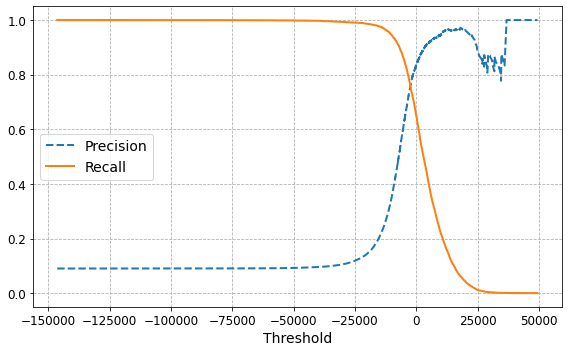

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label="Precision", linestyle="dashed", linewidth=2)
plt.plot(thresholds, recalls[:-1], label="Recall", linestyle="solid", linewidth=2)
plt.xlabel("Threshold")
plt.legend(loc="center left")
plt.grid(linestyle="dashed")
save_fig("precision_recall_vs_threshold")
plt.show()

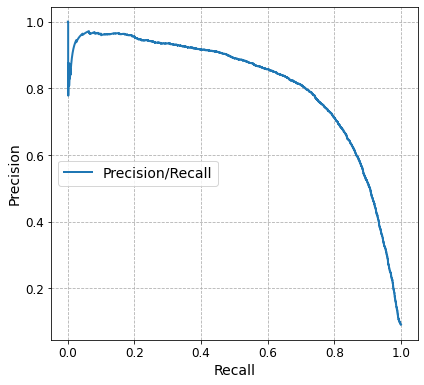

In [37]:
plt.figure(figsize=(6, 6))
plt.plot(recalls, precisions, linestyle="solid", linewidth=2, label="Precision/Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(linestyle="dashed")
plt.legend(loc="center left")
plt.gca().set_aspect(1)
save_fig("precision_vs_recall")
plt.show()

In [38]:
# Let's choose threshold to obtain 90% of the precision.
id_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[id_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [39]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [40]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

### **5. ROC CURVE**

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

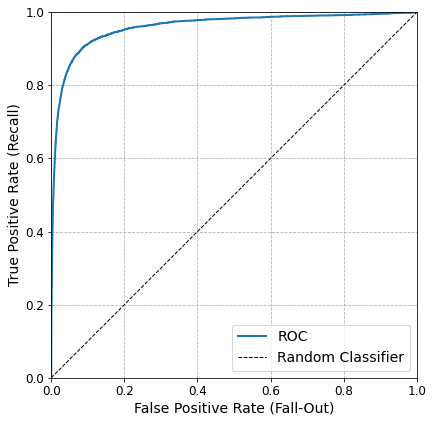

In [42]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle="solid", linewidth=2, label="ROC")
plt.plot([0, 1], [0, 1], linestyle="dashed", linewidth=1,
        label="Random Classifier", color="black")
plt.gca().set_aspect(1)
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid(linestyle="dashed")
plt.axis([0, 1, 0, 1])
save_fig("roc_curve")
plt.show()

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
y_probas_forest[:5]

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.99, 0.01]])

In [45]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

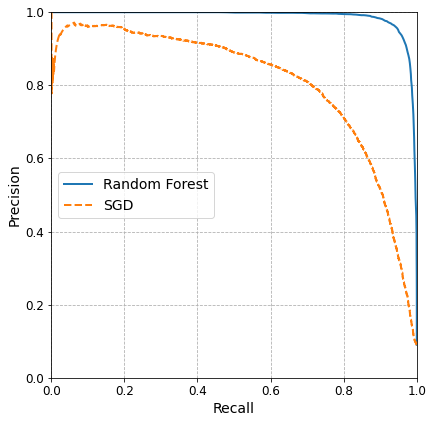

In [46]:
plt.figure(figsize=(6, 6))
plt.plot(recalls_forest, precisions_forest, linestyle="solid", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, linestyle="dashed", linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.gca().set_aspect(1)
plt.axis([0, 1, 0, 1])
plt.grid(linestyle="dashed")
plt.legend(loc="center left")
save_fig("precision_recall_forest_sgd")
plt.show()

In [47]:
y_train_pred_forest = (y_probas_forest[:, 1] >= 0.5)
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [48]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [49]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [50]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

## ![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white) **MULTICLASS CLASSIFICATION**

In [51]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # SVMs do not scale well with large datasets.
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [52]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [53]:
class_id = some_digit_scores.argmax()
class_id

5

In [54]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [55]:
svm_clf.classes_[class_id]

'5'

In [56]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [57]:
len(ovr_clf.estimators_)  # 10 - one for an each class (0, 1, 2, ..., 9).

10

In [58]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [59]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [60]:
sgd_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

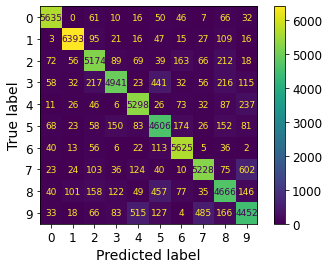

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
plt.rc("font", size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

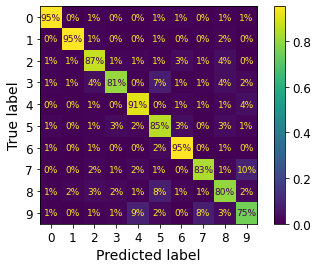

In [62]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true",
                                        values_format=".0%")

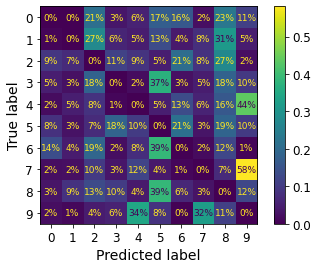

In [63]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight, normalize="true",
                                        values_format=".0%")

## ![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white) **MULTILABEL CLASSIFICATION**

In [64]:
import numpy as np

y_train_large = (y_train >= "7")
y_train_odd = (y_train.astype(np.int8) % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [65]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [66]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [67]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

In [68]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])
chain_clf.predict([some_digit])

array([[0., 1.]])

## ![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white) **MULTIOUTPUT CLASSIFICATION**

In [69]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test


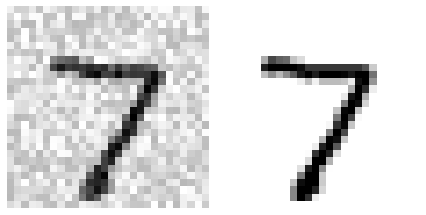

In [70]:
plt.subplot(121)
plot_digit(X_test_mod[0])
plt.subplot(122)
plot_digit(y_test_mod[0])
save_fig("noisy_digit_example")
plt.show()

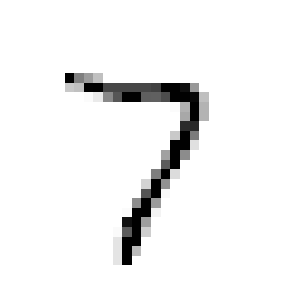

In [71]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("digit_cleaned_by_knn")
plt.show()